**Name:** Yidu Wu

**EID:** yiduwu2

# CS5489 - Tutorial 10
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize Keras and Tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

2.2.4-tf 1.13.2


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [3]:
imgdata = []
classes = []

# load the zip file
filename = 'cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):
        
        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class 

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile)
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)
        
        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)
        
zfile.close()
print(len(imgdata))
print(img.size)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


800
589824


Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

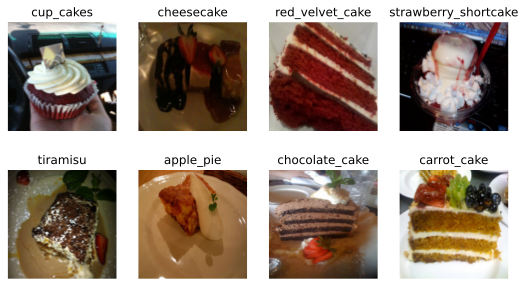

In [4]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])    
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [5]:
Xraw = zeros((len(imgdata), 224, 224, 3))
for i,img in enumerate(imgdata):
    x = image.img_to_array(img)*255   # preprocessing expects range [0,255]
    x = expand_dims(x, axis=0)
    Xraw[i,:] = x

Finally, we convert the class label strings into class numbers.

In [6]:
# convert class strings into integers
print("class labels (strings):", unique(classes))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(classes)
print("Converted labels:")
print(Y)
Yb = keras.utils.to_categorical(Y)

class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## 2. Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` will overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [11]:
import tensorflow.keras.applications.resnet50 as resnet

Xim = resnet.preprocess_input(Xraw)

model_f = resnet.ResNet50(weights='imagenet', 
                          include_top=False,  # remove the classification layer
                          pooling='avg')      # apply GlobalAveragePooling


Extract features from Resnet50, call it `Xf`.

In [10]:
# compute the features
Xf = model_f.predict(Xim)
print(Xf.shape)

(800, 2048)


## 3. Train a classifier
Split the data into training and testing for the classifier.

In [9]:
# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainXraw, testXraw,   # raw images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, Xraw, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf.shape)
print(testXf.shape)

(640, 2048)
(160, 2048)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [12]:
paramgrid = {'C': logspace(-3,3,13)}
print(paramgrid)
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)
svmcv.fit(trainXf, trainY);
predY = svmcv.predict(testXf)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " + str(acc))


{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  65 | elapsed:   51.0s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   56.6s finished


test accuracy = 0.65625


# 4. Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [14]:
# get the class labels
predYcl = le.inverse_transform(predY)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off() 

Now look at the confusion matrix

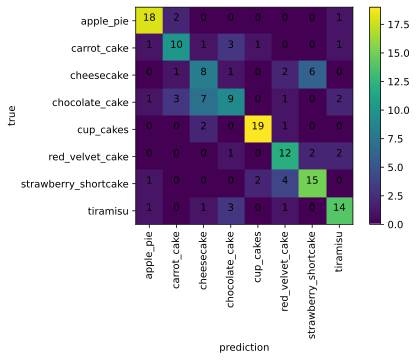

In [16]:
CM = metrics.confusion_matrix(testY, predY)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**

## 5. Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

In [18]:
# compatible with v1 or v2
def tf_compat():
    if tf.__version__[0] == '1':
        return (tf.set_random_seed, 'acc')
    else:
        return (tf.random.set_seed, 'accuracy')
    
tf_set_seed, accname = tf_compat()

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_'+accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_'+accname][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [30]:
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# create the base pre-trained model with-out the classifier
# using global average pooling
base_model = resnet.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# start with the output of the ResNet50 (1x1x2048) 
x = base_model.output

# fully-connected layer (1 x32)
# (only two classes so don't need so many)
x = Dense(128, activation='relu')(x)

# finally, the softmax for the classifier (2 classes)
predictions = Dense(8, activation='softmax')(x)


In [31]:
# build the model for training
# - need to specify the input layer and the output layer
model_ft = Model(inputs=base_model.input, outputs=predictions)

# fix the layers of the ResNet50.
for layer in base_model.layers:
    layer.trainable = False

# compile the model - only the layers that we added will be trained
model_ft.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# generate a fixed validation set using 10% of the training set
vtrainXim, validXim, vtrainYb, validYb = \
  model_selection.train_test_split(trainXim, trainYb, 
  train_size=0.9, test_size=0.1, random_state=6487)

# validation data
validset  = (validXim, validYb)


In [33]:
def add_gauss_noise(X, sigma2=0.1):  #0.05
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.1,     # image shifting
    height_shift_range=0.1,    # image shifting
    shear_range=0.1,           # shear transformation
    zoom_range=0.1,            # zooming
    horizontal_flip=True, 
    preprocessing_function=add_gauss_noise, 
)

# fit (required for some normalization augmentations)
datagen.fit(vtrainXim)


In [35]:
# train the model on the new data for a few epochs
bsize = 128
callbacks_list = []
history = model_ft.fit_generator(
            datagen.flow(vtrainXim, vtrainYb, batch_size=bsize),  # data from generator
            steps_per_epoch=len(vtrainXim)/bsize,    # should be number of batches per epoch
            epochs=10,
            callbacks=callbacks_list, 
            validation_data=validset, verbose=True)


Epoch 1/10
5/5 [==============================] - 199s 40s/step - loss: 1.6997 - acc: 0.3681 - val_loss: 1.8346 - val_acc: 0.3438
Epoch 2/10
5/5 [==============================] - 195s 39s/step - loss: 1.3466 - acc: 0.5347 - val_loss: 2.0062 - val_acc: 0.3906
Epoch 3/10
5/5 [==============================] - 197s 39s/step - loss: 1.3021 - acc: 0.5521 - val_loss: 2.1894 - val_acc: 0.4219
Epoch 4/10
5/5 [==============================] - 197s 39s/step - loss: 1.0846 - acc: 0.6146 - val_loss: 2.0940 - val_acc: 0.3906
Epoch 5/10
5/5 [==============================] - 193s 39s/step - loss: 1.0017 - acc: 0.6667 - val_loss: 1.9403 - val_acc: 0.4062
Epoch 6/10
5/5 [==============================] - 194s 39s/step - loss: 0.9133 - acc: 0.6944 - val_loss: 1.5499 - val_acc: 0.5625
Epoch 7/10
5/5 [==============================] - 197s 39s/step - loss: 0.8853 - acc: 0.6944 - val_loss: 2.1916 - val_acc: 0.5000
Epoch 8/10
5/5 [==============================] - 193s 39s/step - loss: 0.8418 - acc: 0.74

In [36]:
predY = argmax(model_ft.predict(testXim, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

test accuracy: 0.4625


In [41]:
def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)
def addNoise2(X):
    return add_corrupt_noise(X)
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise2,  # add per-pixel noise
    data_format='channels_last')

In [ ]:
# CNN
K.clear_session()
random.seed(4487); tf_set_seed(4487)
nn = Sequential()
nn.add(Conv2D(10, (5,5), strides=(2,2), activation='relu', 
              padding='same', input_shape=(224,224,3)))
nn.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same'))
nn.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same'))
nn.add(Flatten())
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=8, activation='softmax'))
earlystop = keras.callbacks.EarlyStopping(monitor='val_'+accname, min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']
          )
history = nn.fit_generator(
            datagen.flow(vtrainXim, vtrainYb, batch_size=50), 
            steps_per_epoch=len(vtrainXim)/50,
            epochs=20,
            callbacks=callbacks_list, 
            validation_data=validset, verbose=True)
plot_history(history)
predY = argmax(nn.predict(testXim, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [43]:
# get the class labels
predYcl = le.inverse_transform(predY)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off() 

_Where you able to improve the accuracy using deep learning? Analyze the errors from your best model._
- **INSERT YOUR ANSWER HERE** Using more features. The last layers of ResNet are high-level semantic features, which could be complemented by low-level or mid-level features.Extract features from multiple layers and concatenate them.